In [32]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable



import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

In [19]:
# Load data set
movies=pd.read_csv('Boltzmann_Machines/ml-1m/movies.dat', sep='::', header=None, engine='python', encoding='latin-1')
users=pd.read_csv('Boltzmann_Machines/ml-1m/users.dat', sep='::', header=None, engine='python', encoding='latin-1')
ratings=pd.read_csv('Boltzmann_Machines/ml-1m/ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')

In [20]:
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [21]:
# prepare training and test set

trainingset=pd.read_csv('Boltzmann_Machines/ml-100k/u1.base', delimiter='\t', header=None)
testset=pd.read_csv('Boltzmann_Machines/ml-100k/u1.test', delimiter='\t', header=None)

In [22]:
# convert to array as it is quicker 

trainingset=np.array(trainingset, dtype='int')
testset=np.array(testset, dtype='int')

In [23]:
# get total no. of movies and users in order to then make a matrix of the data


nb_users= int(max(max(trainingset[:,0]), max(testset[:,0])))
nb_movies=int(max(max(trainingset[:,1]), max(testset[:,1])))
print(nb_users, nb_movies)

943 1682


In [24]:
# make matrix of users in lines and movies in columns

def convert(data):
    new_data=[] #initialise list
    for id_users in range(1, nb_users+1):
        id_movies=data[:,1][data[:,0]==id_users]
        id_ratings=data[:,2][data[:,0]==id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

In [25]:
trainingset=convert(trainingset)
testset=convert(testset)

In [26]:
# convert data into torch sensors

training_set = torch.FloatTensor(trainingset)
test_set=torch.FloatTensor(testset)

In [27]:
training_set


    5     3     4  ...      0     0     0
    4     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    5     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     5     0  ...      0     0     0
[torch.FloatTensor of size 943x1682]

In [28]:
# convert ratings (1-5) into binary ratings 1 (liked) and 0 (not liked)

training_set[training_set==0] = -1 # not rated
training_set[training_set==1] = 0
training_set[training_set==2] = 0
training_set[training_set>=3] = 1

test_set[test_set==0] = -1 # not rated
test_set[test_set==1] = 0
test_set[test_set==2] = 0
test_set[test_set>=3] = 1


In [53]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=1682,
                 n_hin=600,
                 k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
            
            v_[v<0] = v[v<0]
        return v,v_, h_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()
        

In [54]:
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.1)


batch_size_=32

for epoch in range(8):
    loss_ = []
    reconstruction_error=0
    s=0
    for n in range(0, len(training_set)- batch_size_, batch_size_):
        sample_data=training_set[n:n+batch_size_]
        sample_data=Variable(sample_data)
        
        #v=training_set[n:n+batch_size_]
        #sample_data = sample_data.bernoulli()
        v,v1,h1 = rbm(sample_data)

        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        
        loss_.append(loss.data[0])
        
        train_op.zero_grad()
        
        loss.backward()
        train_op.step()
        reconstruction_error+=torch.mean(torch.abs(v-v1))
        s+=1
    print (' loss: ' + str(reconstruction_error/s))     
    print (np.mean(loss_))

 loss: Variable containing:
1.00000e-02 *
  1.5935
[torch.FloatTensor of size 1]

0.891826235015
 loss: Variable containing:
1.00000e-02 *
  1.4161
[torch.FloatTensor of size 1]

1.59331275677
 loss: Variable containing:
1.00000e-02 *
  1.3686
[torch.FloatTensor of size 1]

1.07633077687
 loss: Variable containing:
1.00000e-02 *
  1.3274
[torch.FloatTensor of size 1]

1.24074896451
 loss: Variable containing:
1.00000e-02 *
  1.3004
[torch.FloatTensor of size 1]

1.09722532075
 loss: Variable containing:
1.00000e-02 *
  1.2770
[torch.FloatTensor of size 1]

1.06569303315
 loss: Variable containing:
1.00000e-02 *
  1.2536
[torch.FloatTensor of size 1]

0.878612649852
 loss: Variable containing:
1.00000e-02 *
  1.2394
[torch.FloatTensor of size 1]

1.03572029903


In [14]:
# now predict on new observations 



test_loss=0                                       # need to measure error. loss function could use RMSE (done in autoencoders)
s=0 
for id_user in range(0, nb_users): #batch learning
    v=training_set[id_user:id_user+ 1]  # training set inputs are used to activate neurons of our RBM
    vt=test_set[id_user:id_user + 1] #target
    if len(vt[vt>=0])>0:
        _,h =rbm.sample_h(v)
        _,v=rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0]-v[vt>=0]))   #update train loss
        s+=1.
print ('test loss: ' + str(test_loss/s))


test loss: 0.24095350307469346


In [65]:
vis1=v1.data.numpy()
vis0=v.data.numpy()

In [68]:
print(vis0[0])

[ 1. -1. -1. ..., -1. -1. -1.]


In [95]:
sum(vis0[10]!=vis1[10])

20

In [96]:
sum(vis0[10]==1)

144

In [103]:
# weights

weights=rbm.W
weights=weights.data.numpy()

weights=weights.reshape(1009200)
from scipy import stats, integrate
import matplotlib.pyplot as plt
#import pandas as pd


import seaborn as sns
sns.set(color_codes=True)

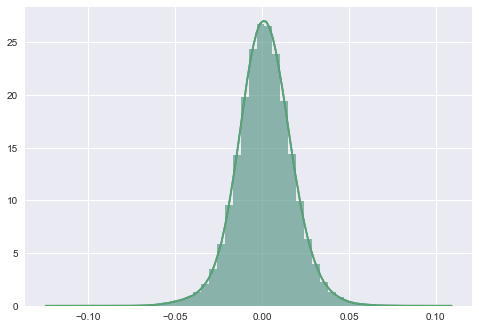

In [105]:

sns.distplot(weights)
plt.show()